<h1>Regression</h1>

In [70]:
import csv
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

<h2>Laden der Daten</h2>

In [71]:
df = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

In [72]:
df_wdi = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WDI.HM-2.csv", parse_dates=["Date"])

<h2>Vorverarbeitung der Daten</h2>

In [73]:
#Berechnung der Returns für Log
df_wdi["returns"] = (df_wdi.Close.pct_change() + 1)

#Change Date für df_wdi
df_wdi["Date"] = pd.to_datetime(df_wdi.Date).apply(lambda x: x.date())

In [74]:
#Berechnung der Lags
def lagit(df, lags, shifter):
    names = []
    for i in range(1, lags+1):
        df["Lag_"+str(i)] = df[shifter].shift(i)
        names.append("Lag_"+str(i))
    df.dropna(inplace=True)    
    return names, df

In [75]:
#add data to df
def calculate_sentiment(df):
    #create a DF with the dates (as dates) and the sum of all tweets grouped by the date
    df_date_count = pd.DataFrame({"count_tweets": df["tweet_id"].groupby(pd.to_datetime(df["created_at"]).apply(lambda x: x.date())).count()}).reset_index()
    
    #create a DF with the dates, tweet_id and the sentiment values cahnges to 1, 0 and -1 for calculating the sum grouped by
    #by the date. 
    df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                                 "tweet_id": df["tweet_id"], 
                                 "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert]}).reset_index(drop=True)
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

<h2>Lineare Regression mit Statsmodels</h2>

In [76]:
def regression(df, regressor, output, log=False):
    if log:
        df["log_"+output] = np.log(df[output])
        output = ("log_" + output)
    
    train, test = train_test_split(df, shuffle=False, test_size=0.3, random_state=0)
    
    train_x = train[regressor]
    train_y = train[output]
    
    test_x = test[regressor]
    test_y = test[output]
    
    train_x, train_y = np.array(train_x), np.array(train_y)
    test_x, test_y = np.array(test_x), np.array(test_y)
    
    train_x = sm.add_constant(train_x)
    test_x = sm.add_constant(test_x)
    
    model = sm.OLS(train_y, train_x).fit()
    
    predictions = model.predict(test_x)
    
    print_model = model.summary()
    
    #print(predictions)
    print(print_model)
    return model, predictions, test

<h2>Ausführung</h2>

In [86]:
output = "returns"
regressor = "bert_pos_percent_all"

In [87]:
df_sentiment = calculate_sentiment(df)
df_wdi_sentiment = df_wdi.merge(df_sentiment.rename(columns={"created_at": "Date"}), how="left", on="Date").fillna(0)
df_wdi_sentiment["intraday_change"] = df_wdi_sentiment["Adj Close"] - df_wdi_sentiment["Open"]

lagnames, df_wdi_sentiment = lagit(df_wdi_sentiment, 5, regressor)

In [88]:
reg_model, reg_predictions, test = regression(df_wdi_sentiment, lagnames, output)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3111
Date:                Thu, 18 Aug 2022   Prob (F-statistic):              0.906
Time:                        20:42:47   Log-Likelihood:                 1701.5
No. Observations:                 795   AIC:                            -3391.
Df Residuals:                     789   BIC:                            -3363.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.003    314.240      0.0

In [89]:
test

,Date,Open,High,Low,Close,Adj Close,Volume,returns,count_tweets,count_bert_neg,...,bert_pos_percent_all,bert_neg_percent_all,bert_pos_percent,bert_neg_percent,intraday_change,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
800,2019-03-25,102.000000,102.000000,93.300003,99.400002,99.271622,7371,0.994000,147.0,38.0,...,0.149660,0.258503,0.366667,0.633333,-2.728378,0.164773,0.134409,0.145833,0.205128,0.074627
801,2019-03-26,100.800003,129.050003,100.400002,124.300003,124.139458,8921,1.250503,292.0,93.0,...,0.099315,0.318493,0.237705,0.762295,23.339455,0.149660,0.164773,0.134409,0.145833,0.205128
802,2019-03-27,126.500000,127.550003,118.400002,123.400002,123.240623,2501,0.992759,193.0,83.0,...,0.124352,0.430052,0.224299,0.775701,-3.259377,0.099315,0.149660,0.164773,0.134409,0.145833
803,2019-03-28,122.900002,124.000000,122.900002,123.250000,123.090813,927,0.998784,195.0,65.0,...,0.133333,0.333333,0.285714,0.714286,0.190811,0.124352,0.099315,0.149660,0.164773,0.134409
804,2019-03-29,120.349998,120.500000,111.000000,112.400002,112.254829,2821,0.911968,385.0,162.0,...,0.080519,0.420779,0.160622,0.839378,-8.095169,0.133333,0.124352,0.099315,0.149660,0.164773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2020-07-27,2.228000,2.516000,1.850000,1.850000,1.850000,25093,0.949107,385.0,98.0,...,0.062338,0.254545,0.196721,0.803279,-0.378000,0.045855,0.032040,0.038224,0.034816,0.052121
1137,2020-07-28,1.847000,1.869200,1.828000,1.852600,1.852600,2035,1.001405,325.0,150.0,...,0.055385,0.461538,0.107143,0.892857,0.005600,0.062338,0.045855,0.032040,0.038224,0.034816
1138,2020-07-29,1.850000,2.092500,1.830000,2.050000,2.050000,19941,1.106553,429.0,110.0,...,0.072261,0.256410,0.219858,0.780142,0.200000,0.055385,0.062338,0.045855,0.032040,0.038224
1139,2020-07-30,2.055000,2.100000,1.928000,1.928000,1.928000,3200,0.940488,294.0,71.0,...,0.037415,0.241497,0.134146,0.865854,-0.127000,0.072261,0.055385,0.062338,0.045855,0.032040


In [90]:
sub_input = "Lag_4"

In [91]:
reg_model, reg_predictions, test = regression(df_wdi_sentiment, sub_input, output)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.003535
Date:                Thu, 18 Aug 2022   Prob (F-statistic):              0.953
Time:                        20:43:12   Log-Likelihood:                 1700.7
No. Observations:                 795   AIC:                            -3397.
Df Residuals:                     793   BIC:                            -3388.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0016      0.002    494.674      0.0

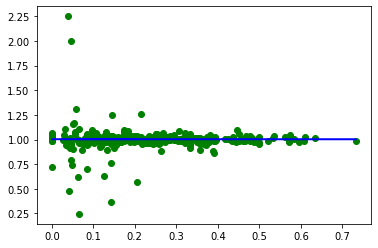

In [92]:
plt.scatter(test[sub_input], test[output], color="green")
plt.plot(test[sub_input], reg_predictions, color="blue")
plt.show()

In [ ]:
len(df_wdi_sentiment)

<h2>Plots for Visualisation</h2>

In [ ]:

plt.scatter(df_wdi_sentiment.Date, np.log(df_wdi_sentiment["Adj Close"]), color="blue")
plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_neg_percent_all, color="red")
plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_neg_percent, color="orange")


plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_pos_percent_all, color="green")


plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_pos_percent, color="yellow")


plt.show

In [ ]:
x = np.log(df_wdi_sentiment["bert_pos_percent_all"])
y = np.log(df_wdi_sentiment["Adj Close"])

plt.scatter(x, y)
plt.show()

<h2>Test</h2>